In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.nn.modules import activation
import torch
from torch import nn
import numpy as np
import pickle
import random


# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [ ]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

"\nExperimenting with Multi-Class Sequence Classification using RNNs and LSTMs\nSteps :\n1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n"

Train Seqs: (210, 40)
Train Labels: (210,)
Test Seqs: (90, 40)
Test Labels: (90,)


C:\Users\erodriguez\AppData\Local\Temp\ipykernel_9668\2854640225.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Results/sequence_data.png'

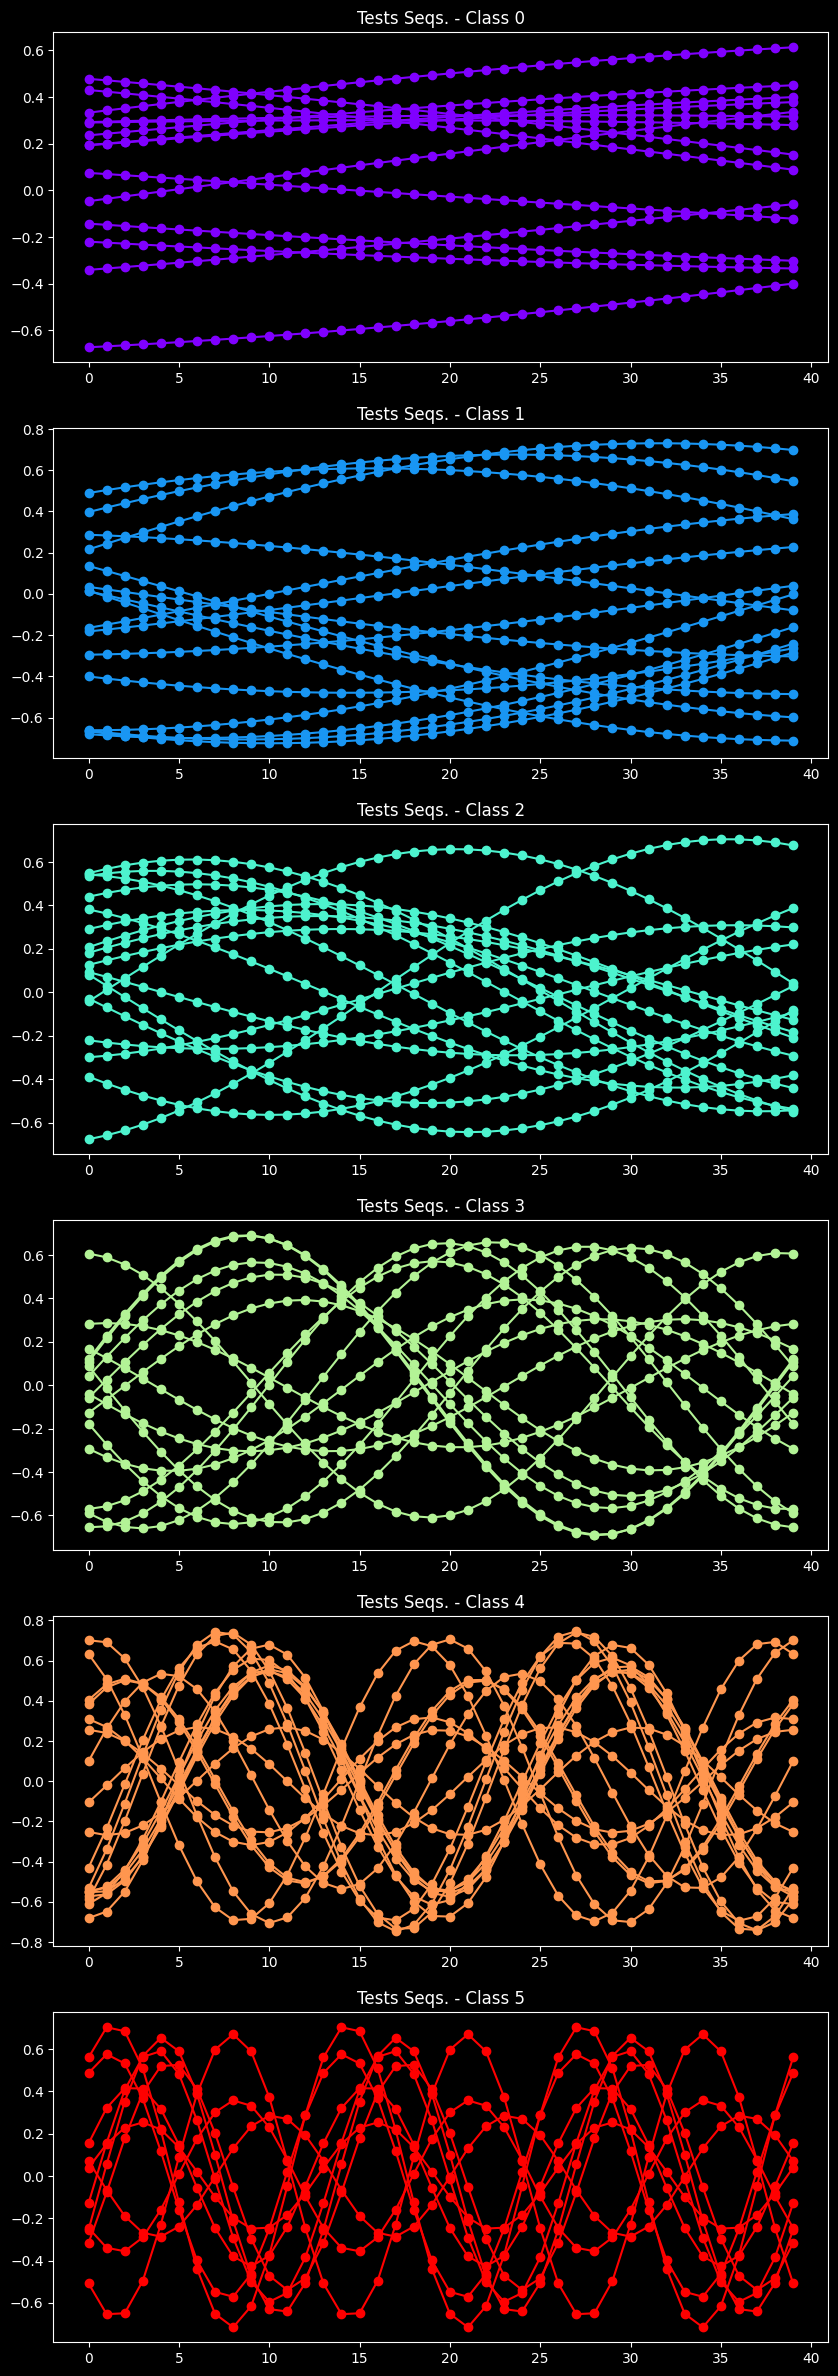

In [2]:
data_path = 'C:/eduard/uni/3er/trim3/DeepLearning/P2/Data'

file_path = os.path.join(data_path,'P2_E1.npz') 
data = np.load(file_path)
X_train, X_test = data['X_train'],data['X_test'] 
Y_train, Y_test = data['Y_train'],data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes,1, figsize=(10, 5*n_classes))
for class_idx in range(0,n_classes):
  axs[class_idx].plot(X_test[Y_test==class_idx,:].T,'-o',
                      c=colors[class_idx])
  axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()
fig.savefig('Results/sequence_data.png')

# Sol 1. 

In [3]:
'''
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate the 
   results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

'\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate the \n   results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n'

## Example code

In [ ]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class SequenceClassifier(nn.Module):
  def __init__(self,
               input_size : int = 1, 
               hidden_size : int = 5, 
               num_layers = 1,
               use_lstm : bool = False,
               n_classes : int = 6):
    # Define RNN or LSTM architecture
    super().__init__()
    self.use_lstm = use_lstm
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size, 
                         num_layers=num_layers, batch_first = True)
    self.softmax = nn.LogSoftmax(dim=1)
    self.last_linear = nn.Linear(hidden_size, n_classes)

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    if(not self.use_lstm):
      last_hidden_state = last_states[-1,:,:].squeeze(0) 
    else:
      last_hidden_state = last_states[0][-1,:,:].squeeze(0)
    # Get sequence label probability using the last hidden state
    output = self.softmax(self.last_linear(last_hidden_state))
    return output


In [ ]:
# Conduct Gradient Descent Optimization over the training dataset

def train_sequence_classifier(X_train, Y_train, seq_classifier, optimizer, loss_func, epochs=100):
    loss_its = [] 
    for iter in range(epochs):
      optimizer.zero_grad()
      output = seq_classifier(X_train)
      loss = loss_func(output,Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)


In [ ]:
# Compute accuracy accross testing dataset
def test_sequence_classifier(X_test, Y_test, seq_classifier):
    output = seq_classifier(X_test)
    output_labels = output.argmax(dim=1)
    accuracy = ((output_labels==Y_test)*1.0).mean()
    print(f'Test Accuracy: {accuracy.item()}')
    confusion_matrix = np.zeros((n_classes,n_classes))
    for class_idx in range(0,n_classes):
        for pred_idx in range(0,n_classes):
            confusion_matrix[class_idx,pred_idx] = ((output_labels[Y_test==class_idx]==pred_idx)*1.0).mean()
    # print(f'Confusion Matrix: \n {confusion_matrix}')
    return accuracy.item()

In [7]:
# Dataset to PyTorch format
X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2)# .cuda()
Y_train_pt = torch.from_numpy(Y_train).long()# .cuda()
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2)# .cuda()
Y_test_pt = torch.from_numpy(Y_test).long()# .cuda()

# Define Cross entropy loss
loss_func = nn.CrossEntropyLoss()

input_size = 1 
exp_hidden_size = [5, 5, 5, 10, 10, 10, 20, 20, 20]
exp_num_layers = [1,2,3] * 3
exp_use_lstm = [True] * 9


losses_models = {}
test_accuracy_models = {}
for hidden_size, num_layers, use_lstm in zip(exp_hidden_size,exp_num_layers,exp_use_lstm):
  model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
  print(f'Training: {model_id}')
  seq_classifier = SequenceClassifier(use_lstm=use_lstm,num_layers=num_layers,hidden_size=hidden_size)
  # seq_classifier# .cuda()
  optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=1e-3)
  losses_models[model_id] = train_sequence_classifier(X_train_pt, Y_train_pt, 
                            seq_classifier, optimizer, 
                            loss_func, epochs=1000)
  test_accuracy_models[model_id]  = test_sequence_classifier(X_test_pt,Y_test_pt,seq_classifier)



Training: H5_NL1_LSTM1
Final loss: 1.2248640060424805
Test Accuracy: 0.4555555582046509
Training: H5_NL2_LSTM1
Final loss: 0.7493442893028259
Test Accuracy: 0.6111111044883728
Training: H5_NL3_LSTM1
Final loss: 0.9538395404815674
Test Accuracy: 0.5777778029441833
Training: H10_NL1_LSTM1
Final loss: 0.45507436990737915
Test Accuracy: 0.7444444298744202
Training: H10_NL2_LSTM1
Final loss: 0.49813133478164673
Test Accuracy: 0.7111111283302307
Training: H10_NL3_LSTM1
Final loss: 0.41707733273506165
Test Accuracy: 0.6333333253860474
Training: H20_NL1_LSTM1
Final loss: 0.33719155192375183
Test Accuracy: 0.7888888716697693
Training: H20_NL2_LSTM1
Final loss: 0.18737447261810303
Test Accuracy: 0.7666666507720947
Training: H20_NL3_LSTM1
Final loss: 0.18507294356822968
Test Accuracy: 0.8666666746139526


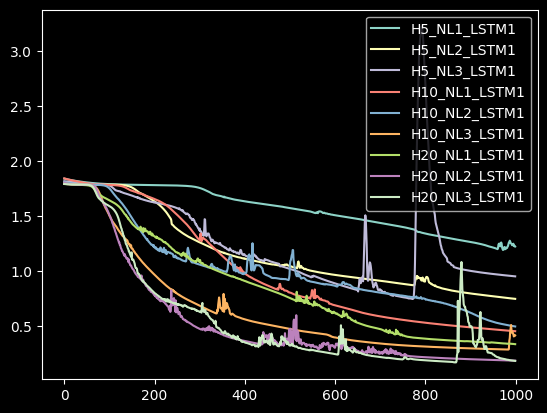

,H5_NL1_LSTM1,H5_NL2_LSTM1,H5_NL3_LSTM1,H10_NL1_LSTM1,H10_NL2_LSTM1,H10_NL3_LSTM1,H20_NL1_LSTM1,H20_NL2_LSTM1,H20_NL3_LSTM1
accuracy %,45.555556,61.11111,57.77778,74.444443,71.111113,63.333333,78.888887,76.666665,86.666667


In [8]:
import pandas as pd

for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
             index=test_accuracy_models.keys()).transpose()

In [ ]:
# learning rate mas bajo, weight decay, mas epochs, batch, !!mirar inicializacion de pesos (quizas es demasiado grande)!!

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [ ]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis. 

For this exercise, you have training.pkl and testing_corrupted.pkl files. 
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test. 
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with 
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted 
with a new char ("-"), while the training set has been transmitted correctly. 

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps : 
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Analyze the data distribution and define the new alphabet.
3. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
4. Train a sequential model to decode the corrupted test data. 
5. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
6. Try to improve the performance by applying some improvements over the model: stacked LSTMs, 
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
7. Visualize and discuss on the final results.
'''

# Sol 2.

# 2.1: Discover the keyword used to encrypt the plaintext data

In [32]:
with open(data_path+'/training.pkl', 'rb') as pkl_file:
  train = pickle.load(pkl_file)

with open(data_path+'/testing_corrupted.pkl', 'rb') as pkl_file:
  test = pickle.load(pkl_file)
vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Predefined vocabulary

In [33]:
# Corrupted Testing Sequence Visualization
def decode_message(message, vocabulary):
  decoded = ''
  for letter_code in message:
    decoded += vocabulary[letter_code]
  return decoded

idx_sample = 2
print(f'Train Message F (not corrupted): {decode_message(train[idx_sample][0],vocabulary)}')
print(f'Train Message decrypted: {decode_message(train[idx_sample][1],vocabulary)}')

print(f'Test Message encrypted and corrupted: {decode_message(test[idx_sample][0],vocabulary)}')
print(f'Test Message decrypted (must be used only for evaluation purposes): {decode_message(test[idx_sample][1],vocabulary)}')


Train Message F (not corrupted): XRACLIOIWHICKRTBMCCGHGLGSNVOXLZG
Train Message decrypted: ITHOUGHTYOULIKEDTOLEARNNEWTHINGS
Test Message encrypted and corrupted: -CXLGNH-LX-KQO-PAWJEPGANAJVHCAXG
Test Message decrypted (must be used only for evaluation purposes): HEEXPLAINEDTOHERHISCIRCUMSTANCES


In [34]:
def vigenere_decode(cipher_text, decrypted_text, password_length):
    cipher_text = cipher_text.upper()
    decrypted_text = decrypted_text.upper()
    key = ""

    for i in range(password_length):
        cipher_char = cipher_text[i]
        decrypted_char = decrypted_text[i]
        if cipher_char.isalpha() and decrypted_char.isalpha():
            cipher_index = ord(cipher_char) - ord('A')
            decrypted_index = ord(decrypted_char) - ord('A')
            key_shift = (decrypted_index - cipher_index) % 26
            key_char = chr(key_shift + ord('A'))
            key += key_char
        else:
            key += cipher_char

    return key

In [35]:
password_length=7
a=decode_message(train[idx_sample][1],vocabulary)
b=decode_message(train[idx_sample][0],vocabulary)
key = vigenere_decode(b[0:password_length],a[0:password_length], password_length)
others=[]
for j in range (len(train)):
    a=decode_message(train[j][1],vocabulary)
    b=decode_message(train[j][0],vocabulary)
    for i in range (0,32-password_length,password_length):
      if key!=vigenere_decode(b[i:i+password_length],a[i:i+password_length], password_length):
       others.append(vigenere_decode(b[i:i+password_length],a[i:i+password_length], password_length))
print(others)
print(key)

[]
LCHMJYT


## 2.2: Analyze the data distribution and define the new alphabet

In [47]:
def get_frequency(data, vocabulary):
    frequency_enc = np.zeros((len(vocabulary)))
    frequency_dec = np.zeros((len(vocabulary)))
    for i in range(len(data)):
        for j in range(len(data[i][0])):
            frequency_enc[data[i][0][j]] += 1
        for j in range(len(data[i][1])):
            frequency_dec[data[i][1][j]] += 1
    return frequency_enc, frequency_dec

def plot_frequency(train, test, vocabulary):
    plt.figure(figsize=(20, 10))
    train_norm = train / np.sum(train)
    test_norm = test / np.sum(test)
    plt.bar(vocabulary, train_norm, label='train')
    plt.bar(vocabulary, test_norm, label='test')
    plt.legend()
    plt.show()

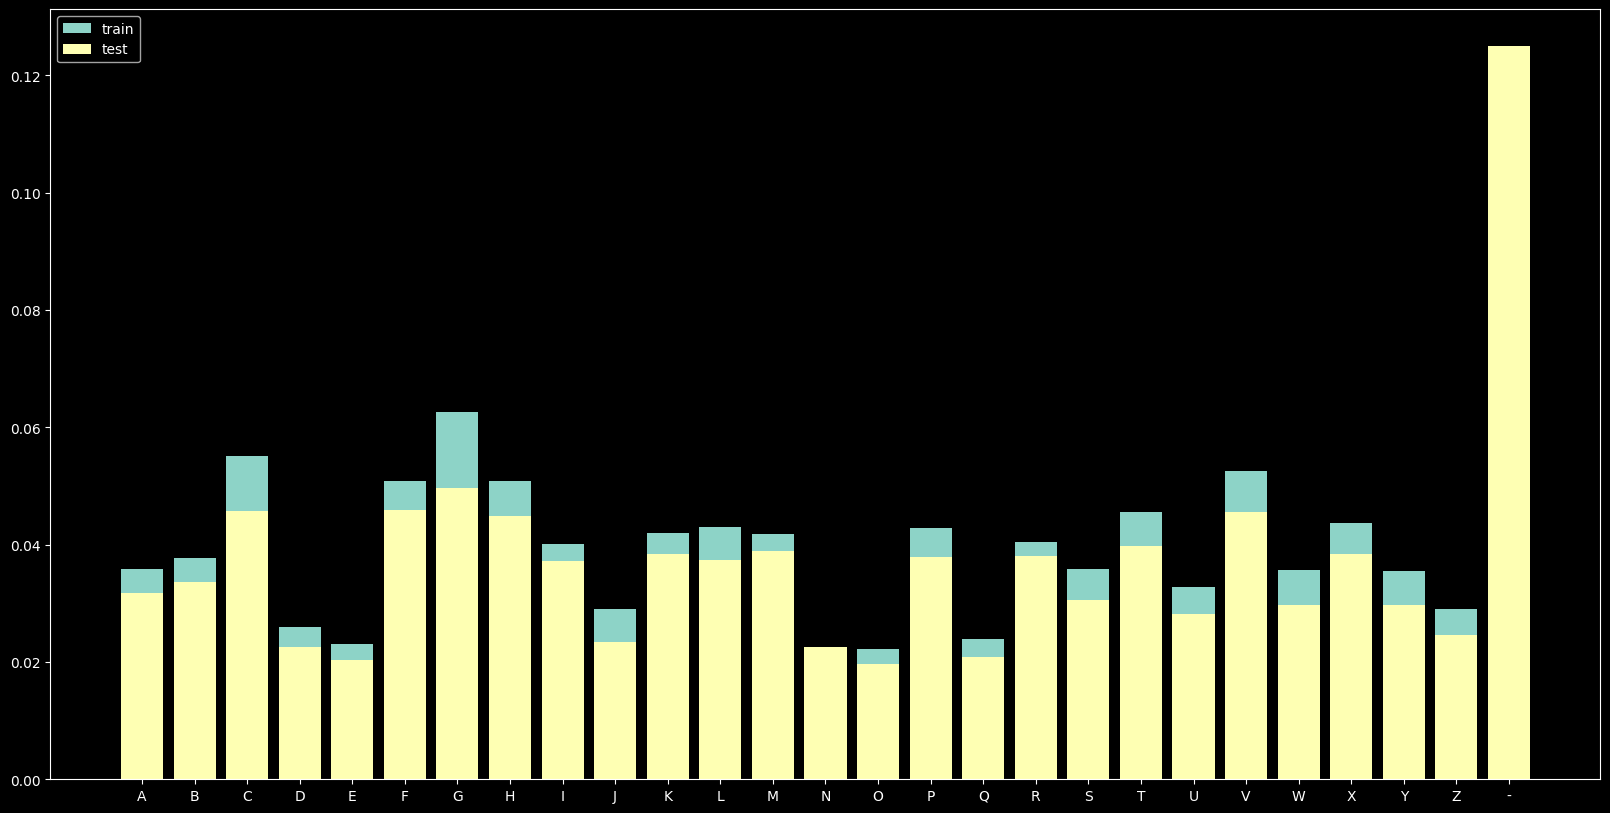

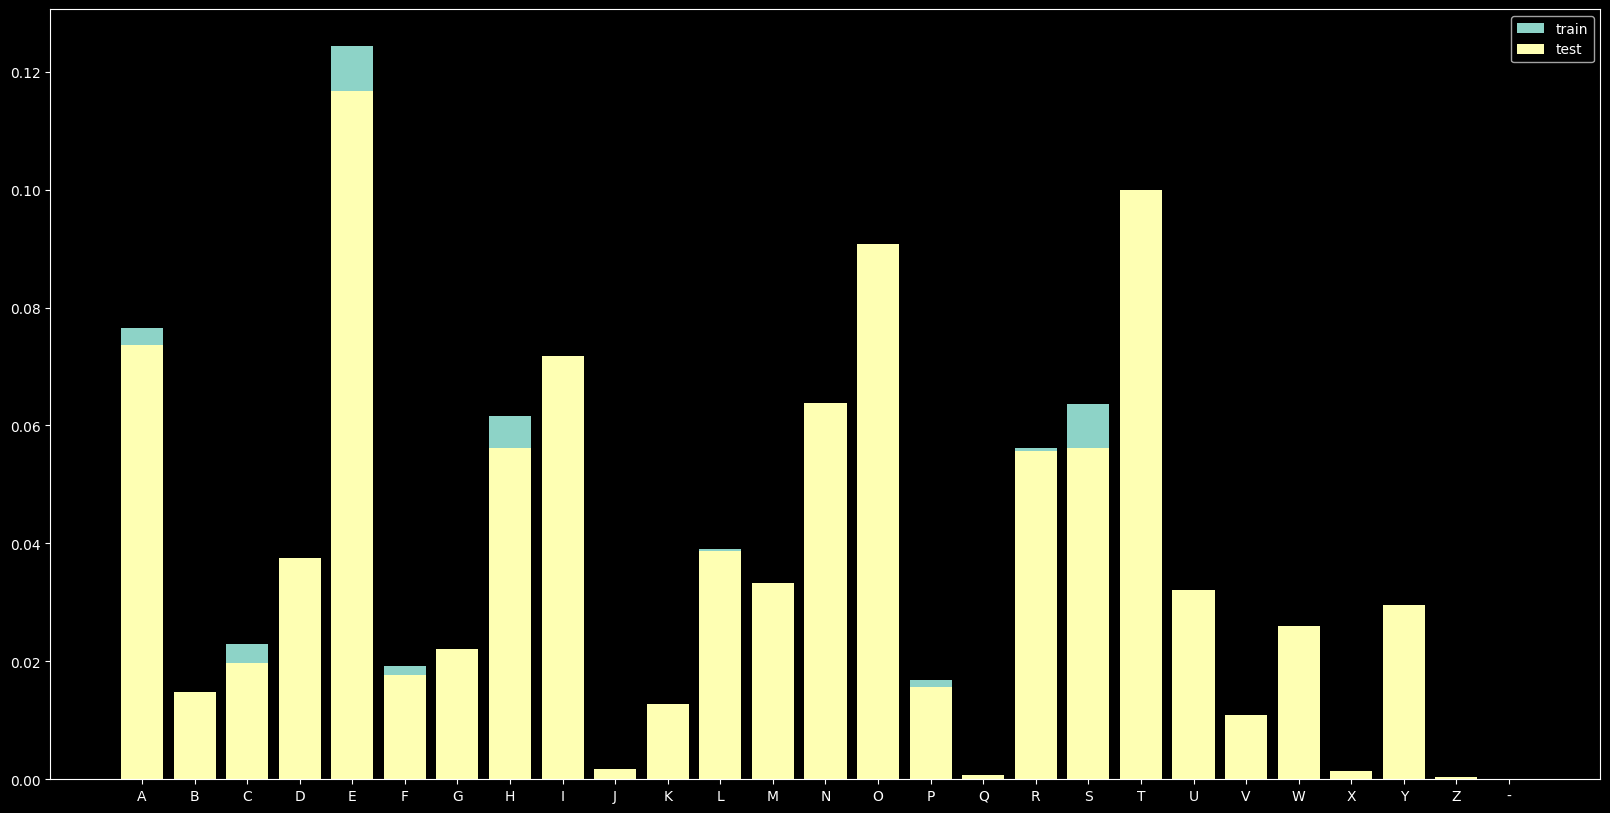

In [48]:
train_enc, train_dec = get_frequency(train, vocabulary)
test_enc, test_dec = get_frequency(test, vocabulary)

plot_frequency(train_enc, test_enc, vocabulary)
plot_frequency(train_dec, test_dec, vocabulary)


In [49]:
def noisy_train(train, noise_level):
    train_noisy = []
    # choose for random elements from the words in the training set and replace them with a 26
    for i in range(len(train)):
        train_noisy.append([train[i][0].clone(), train[i][1].clone()])
        if random.random() < 0.5:
            for j in np.random.choice(32, noise_level, replace=False):
                train_noisy[i][0][j]=torch.LongTensor([26])
    return train_noisy
train_noisy = noisy_train(train, 4)

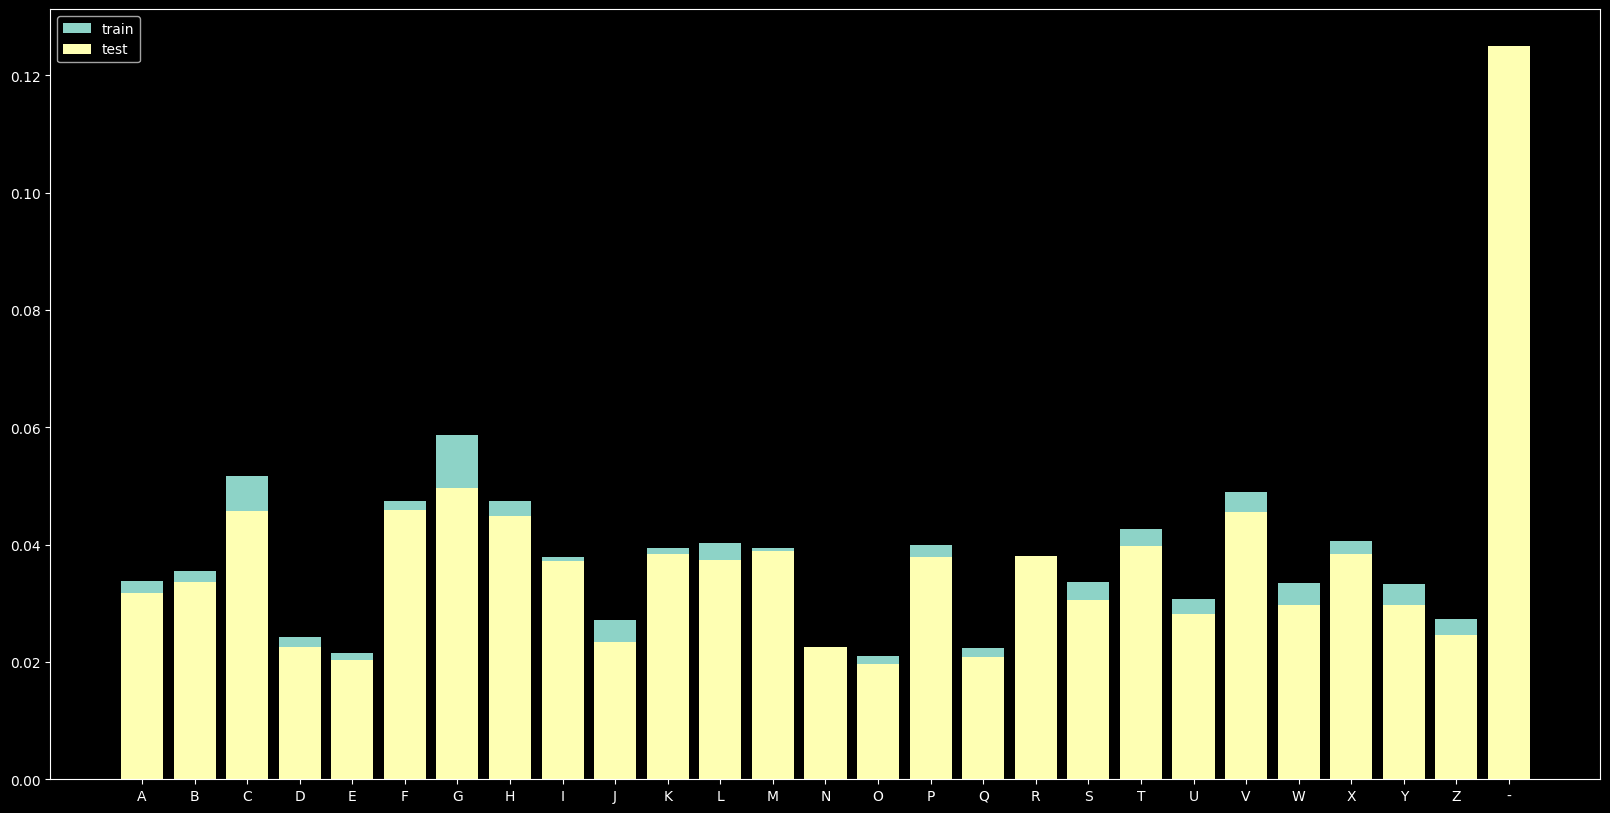

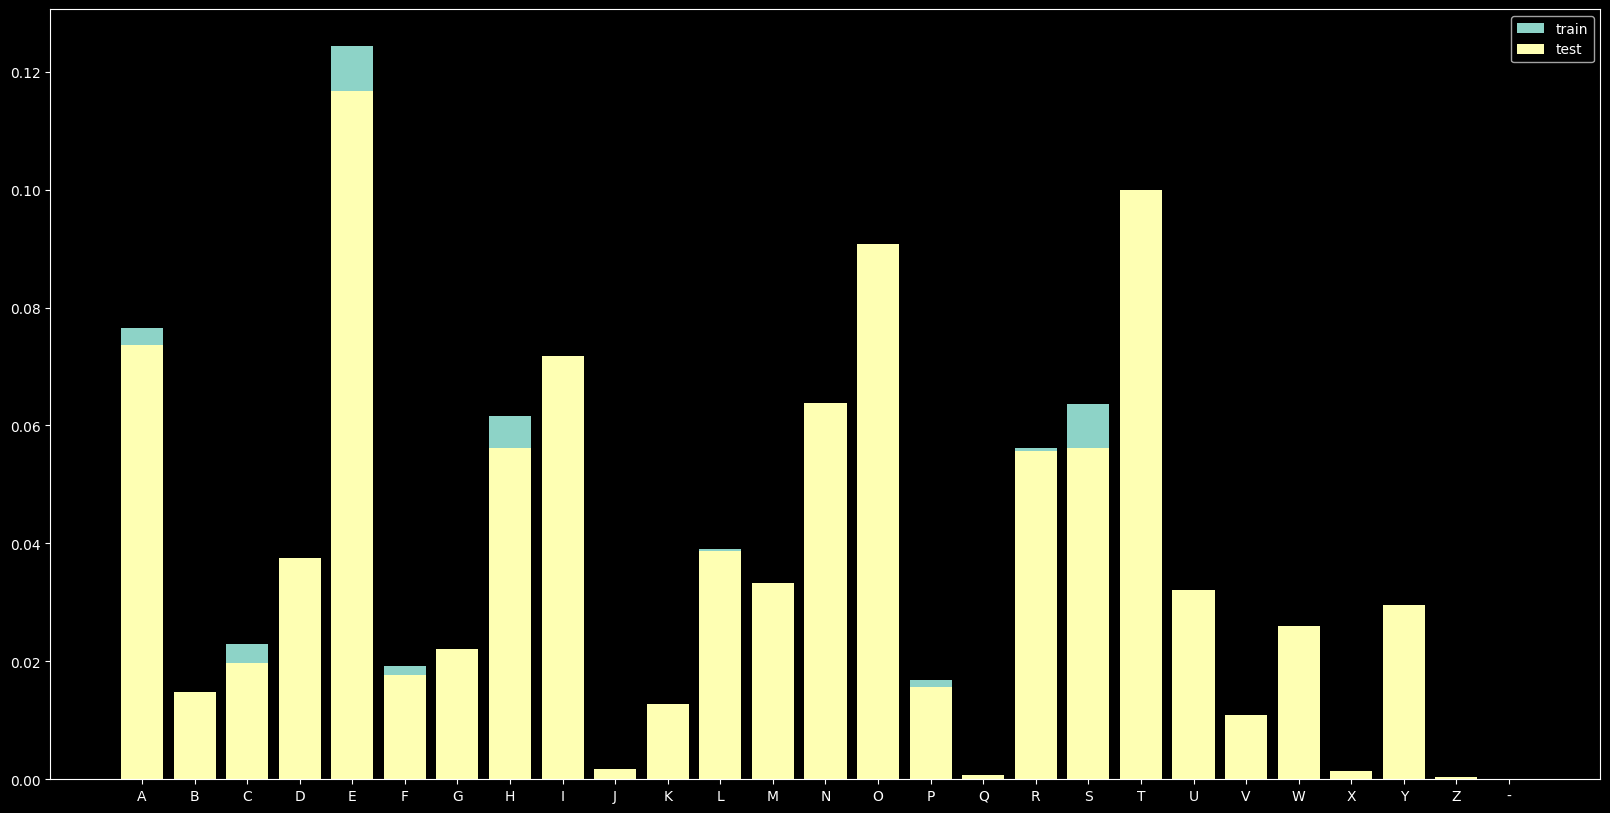

In [51]:
noisy_train_enc, noisy_train_dec = get_frequency(train_noisy, vocabulary)

plot_frequency(noisy_train_enc, test_enc, vocabulary)
plot_frequency(noisy_train_dec, test_dec, vocabulary)

## 2.3 Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples 

## 2.4: Train a sequential model to decode the corrupted test data.

In [91]:
class DecrypterNetwork(nn.Module):
  def __init__(self,
               hidden_size : int = 8, 
               num_layers = 1,
               num_letters = 26,
               letters_embedding_size : int = 8,
               use_lstm : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.hidden_size = hidden_size
    self.num_letters = num_letters
    self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
    self.use_lstm = use_lstm
    self.softmax = nn.Softmax(dim=1)
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size, 
                          num_layers=num_layers, batch_first = True, dropout=0.2)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size, 
                         num_layers=num_layers, batch_first = True, dropout=0.2)
    self.last_linear = nn.Linear(hidden_size,num_letters)

  def forward(self, X):
    N = X.shape[0]
    L = X.shape[1]
    embedded_letters = self.letters_embedder(X)
    # Get hidden states for all letters in the sequence
    hidden_states,_ = self.rnn(embedded_letters)
    # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
    hidden_states_concat = hidden_states.reshape(-1,self.hidden_size) 
    # Get letters probability using the hidden states for each position in the sequence
    letters_loggits = self.last_linear(hidden_states_concat)
    #Use soft-max over logits and reshape to format (N,L,num_letteres)
    letters_probs = self.softmax(letters_loggits).reshape(N,L,self.num_letters)
    return letters_probs

In [143]:
def train_test(model, num_epochs, loss_fn, optimizer, 
               train_encrypted, train_decrypted, test_encrypted, test_decrypted,
               vocabulary, use_cuda = True):
    if(use_cuda):
      model = model#.cuda()
      train_encrypted = train_encrypted.cuda()
      train_decrypted = train_decrypted.cuda()
      test_encrypted = test_encrypted.cuda()
      test_decrypted = test_decrypted.cuda()
    else:
      model = model.cpu()
      train_encrypted = train_encrypted.cpu()
      train_decrypted = train_decrypted.cpu()
      test_encrypted = test_encrypted.cpu()
      test_decrypted = test_decrypted.cpu()

    accuracies, max_accuracy = [], 0
    loss_hist = []
    acc_hist = []
    epochs_hist = []
    test_loss_hist = []

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        optimizer.zero_grad()
        letters_probs = model(train_encrypted)
        loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                       train_decrypted)
        loss.backward() # Backpropagate
        optimizer.step() # Update weights
        loss_hist.append(loss.item())


        # EVALUATION
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                            test_decrypted)
        _,maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        accuracy = ((maxprob_letters_idx==test_decrypted)*1.0).mean() # compute accuracy
        test_loss_hist.append(test_loss.item())
        acc_hist.append(accuracy.item())

        if(epoch%50==0):
          print(f'Epoch {epoch} \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}')
    print(f'Final Epoch \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}')
    return model,loss_hist, test_loss_hist, acc_hist

In [93]:
# Initialize  Decrypter Network 
letters_embedding_size = 8
hidden_size = 16
num_letters = len(vocabulary)
num_layers = 2
use_lstm = True

decrypter_network = DecrypterNetwork(letters_embedding_size=letters_embedding_size,
                                    num_layers=num_layers,
                                    num_letters=num_letters,
                                    hidden_size=hidden_size,
                                    use_lstm=use_lstm)

# Inference over single training sequence
letters_probs = decrypter_network(train[0][0].unsqueeze(0))
print(letters_probs.shape) # (n_sequences, sequence_length, n_letters)

# get index of letter with max probability 
_,maxprob_letters_idx = letters_probs.max(dim=2)
print(f'Original Message decrypted: {decode_message(train[1][0],vocabulary)}')
print(f'Predicted Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}')

torch.Size([1, 32, 27])
Original Message decrypted: XBUSLPOPNIMSWAXUHICFUIIBZCOFHCET
Predicted Message decrypted: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV


In [94]:
# Converting training and testing datasets into PyTorch Tensor (N_seqs, lenght_seqs)
train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in train_noisy],dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in train_noisy],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

test_encrypted.shape
decrypter_network = decrypter_network
decrypted_letters_prob = decrypter_network(test_encrypted)
print(decrypted_letters_prob.shape) # (N_seqs, seq_length, n_letters)

torch.Size([2000, 32, 27])


In [150]:
# Initialize  Decrypter Network 
letters_embedding_size = 16
hidden_size = 16
num_letters = len(vocabulary)
num_layers = 5
use_lstm = True
use_cuda = False

decrypter_network = DecrypterNetwork(letters_embedding_size=letters_embedding_size,
                                    num_layers=num_layers,
                                    num_letters=num_letters,
                                    hidden_size=hidden_size,
                                    use_lstm=use_lstm)

# Define loss, optimizer and run training/evaluation loop
num_epochs=1000                                                                                                            
CE_loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

decrypter_network,loss_hist, test_loss_hist, acc_hist = train_test(decrypter_network, 
                                                 num_epochs, 
                                                 CE_loss, 
                                                 optimizer,
                                                 train_encrypted, train_decrypted, test_encrypted, test_decrypted,
                                                 vocabulary, use_cuda = use_cuda
                                                 )

Epoch 0 	 Train Loss 3.287 	 Test Loss 3.264 	 Test Acc. (%)  3.9
Epoch 50 	 Train Loss 2.891 	 Test Loss 2.908 	 Test Acc. (%)  11.7
Epoch 100 	 Train Loss 2.823 	 Test Loss 2.823 	 Test Acc. (%)  15.4
Epoch 150 	 Train Loss 2.664 	 Test Loss 2.615 	 Test Acc. (%)  23.3
Epoch 200 	 Train Loss 2.572 	 Test Loss 2.489 	 Test Acc. (%)  26.5
Epoch 250 	 Train Loss 2.513 	 Test Loss 2.418 	 Test Acc. (%)  28.5
Epoch 300 	 Train Loss 2.467 	 Test Loss 2.358 	 Test Acc. (%)  30.4
Epoch 350 	 Train Loss 2.422 	 Test Loss 2.297 	 Test Acc. (%)  32.4
Epoch 400 	 Train Loss 2.38 	 Test Loss 2.25 	 Test Acc. (%)  34.4
Epoch 450 	 Train Loss 2.357 	 Test Loss 2.222 	 Test Acc. (%)  34.4
Epoch 500 	 Train Loss 2.321 	 Test Loss 2.174 	 Test Acc. (%)  36.2
Epoch 550 	 Train Loss 2.276 	 Test Loss 2.123 	 Test Acc. (%)  37.6
Epoch 600 	 Train Loss 2.104 	 Test Loss 1.905 	 Test Acc. (%)  44.3
Epoch 650 	 Train Loss 1.974 	 Test Loss 1.739 	 Test Acc. (%)  49.6
Epoch 700 	 Train Loss 1.85 	 Test Loss 

KeyboardInterrupt: 